# Trainign data for detection

Script augments input projects to prepare training dataset for detection models.

This Notebook is a replacement for DTL "Create train set -> Detection"

**Input**:
- Existing annotated Project

**Output**:
- New augumented Project, ready for model training

## Configuration

Edit the following settings for your own case

In [1]:
%matplotlib inline
import supervisely_lib as sly
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
team_name = "jupyter_tutorials"
workspace_name = "cookbook"
project_name = "tutorial_project"

dst_project_name = "tutorial_project_det"

validation_portion = 0.2
image_multiplier = 5

tag_meta_train = sly.TagMeta('train', sly.TagValueType.NONE)
tag_meta_val = sly.TagMeta('val', sly.TagValueType.NONE)

# Obtain server address and your api_token from environment variables
# Edit those values if you run this notebook on your own PC
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [3]:
# Initialize API object
api = sly.Api(address, token)

## Verify input values

Test that context (team / workspace / project) exists

In [4]:
# get IDs of team, workspace and project by names

team = api.team.get_info_by_name(team_name)
if team is None:
    raise RuntimeError("Team {!r} not found".format(team_name))

workspace = api.workspace.get_info_by_name(team.id, workspace_name)
if workspace is None:
    raise RuntimeError("Workspace {!r} not found".format(workspace_name))
    
project = api.project.get_info_by_name(workspace.id, project_name)
if project is None:
    raise RuntimeError("Project {!r} not found".format(project_name))
    
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))
print("Project: id={}, name={}".format(project.id, project.name))

Team: id=30, name=jupyter_tutorials
Workspace: id=76, name=cookbook
Project: id=898, name=tutorial_project


## Get Source Project Meta

In [5]:
meta_json = api.project.get_meta(project.id)
meta = sly.ProjectMeta.from_json(meta_json)
print("Source ProjectMeta: \n", meta)

Source ProjectMeta: 
 ProjectMeta:
Object Classes
+--------+-----------+----------------+
|  Name  |   Shape   |     Color      |
+--------+-----------+----------------+
|  bike  | Rectangle | [246, 255, 0]  |
|  car   |  Polygon  | [190, 85, 206] |
|  dog   |  Polygon  |  [253, 0, 0]   |
| person |   Bitmap  |  [0, 255, 18]  |
+--------+-----------+----------------+
Image Tags
+-------------+--------------+-----------------------+
|     Name    |  Value type  |    Possible values    |
+-------------+--------------+-----------------------+
| cars_number |  any_number  |          None         |
|     like    |     none     |          None         |
|   situated  | oneof_string | ['inside', 'outside'] |
+-------------+--------------+-----------------------+
Object Tags
+---------------+--------------+-----------------------+
|      Name     |  Value type  |    Possible values    |
+---------------+--------------+-----------------------+
|   car_color   |  any_string  |          None     

## Construct Destination ProjectMeta

In [6]:
def process_meta(input_meta):
    output_meta = input_meta.clone(obj_classes=sly.ObjClassCollection())
    
    classes_mapping = {}
    for obj_class in input_meta.obj_classes:
        classes_mapping[obj_class.name] = '{}_bbox'.format(obj_class.name)
        new_obj_class = sly.ObjClass(classes_mapping[obj_class.name], sly.Rectangle, color=obj_class.color)
        output_meta = output_meta.add_obj_class(new_obj_class)
    
    output_meta = output_meta.add_img_tag_meta(tag_meta_train)
    output_meta = output_meta.add_img_tag_meta(tag_meta_val)
    return output_meta, classes_mapping

In [7]:
dst_meta, classes_mapping = process_meta(meta)
print("Destination ProjectMeta:\n", dst_meta)
print("Classes mapping:\n", classes_mapping)

Destination ProjectMeta:
 ProjectMeta:
Object Classes
+-------------+-----------+----------------+
|     Name    |   Shape   |     Color      |
+-------------+-----------+----------------+
|  bike_bbox  | Rectangle | [246, 255, 0]  |
|   car_bbox  | Rectangle | [190, 85, 206] |
|   dog_bbox  | Rectangle |  [253, 0, 0]   |
| person_bbox | Rectangle |  [0, 255, 18]  |
+-------------+-----------+----------------+
Image Tags
+-------------+--------------+-----------------------+
|     Name    |  Value type  |    Possible values    |
+-------------+--------------+-----------------------+
| cars_number |  any_number  |          None         |
|     like    |     none     |          None         |
|   situated  | oneof_string | ['inside', 'outside'] |
|    train    |     none     |          None         |
|     val     |     none     |          None         |
+-------------+--------------+-----------------------+
Object Tags
+---------------+--------------+-----------------------+
|      Name

## Create Destination project

In [8]:
# check if destination project already exists. If yes - generate new free name
if api.project.exists(workspace.id, dst_project_name):
    dst_project_name = api.project.get_free_name(workspace.id, dst_project_name)
print("Destination project name: ", dst_project_name)

Destination project name:  tutorial_project_det


In [9]:
dst_project = api.project.create(workspace.id, dst_project_name)
api.project.update_meta(dst_project.id, dst_meta.to_json())
print("Destination project has been created: id={}, name={!r}".format(dst_project.id, dst_project.name))

Destination project has been created: id=1301, name='tutorial_project_det'


## Iterate over all images, augment them and upload to destination project

In [10]:
def process(img, ann):
    results = []
    
    ann_new = ann.clone(labels=[])
    for label in ann.labels:
        new_class = dst_meta.get_obj_class(classes_mapping[label.obj_class.name])
        new_geometry = label.geometry.to_bbox()
        new_label = label.clone(obj_class=new_class, geometry=new_geometry)
        ann_new = ann_new.add_label(new_label)

    results.append((img, ann_new))

    img_lr, ann_lr = sly.aug.fliplr(img, ann_new)
    results.append((img_lr, ann_lr))

    crops = []
    for cur_img, cur_ann in results:
        for i in range(image_multiplier):
            res_img, res_ann = sly.aug.random_crop_fraction(cur_img, cur_ann, (0.6, 0.9), (0.6, 0.9))
            crops.append((res_img, res_ann))
    results.extend(crops)

    tagged_results = []
    for cur_img, cur_ann in results:
        tag = sly.Tag(tag_meta_val) if random.random() <= validation_portion else sly.Tag(tag_meta_train)
        cur_ann = cur_ann.add_tag(tag)
        tagged_results.append((cur_img, cur_ann))
    
    res_imgs = [img for img, ann in tagged_results]
    res_anns = [ann for img, ann in tagged_results]
    return res_imgs, res_anns

In [11]:
aug_results_debug = None

for dataset in api.dataset.get_list(project.id):
    print('Dataset: {}'.format(dataset.name), flush=True)
    dst_dataset = api.dataset.create(dst_project.id, dataset.name)

    for image in tqdm(api.image.get_list(dataset.id)):
        img = api.image.download_np(image.id)
        ann_json = api.annotation.download(image.id).annotation
        ann = sly.Annotation.from_json(ann_json, meta)
        
        aug_imgs, aug_anns = process(img, ann)
        names = sly.generate_names(image.name, len(aug_imgs))
        
        dst_image_infos = api.image.upload_nps(dst_dataset.id, names, aug_imgs)
        dst_image_ids = [img_info.id for img_info in dst_image_infos]
        api.annotation.upload_anns(dst_image_ids, aug_anns)
        
        if aug_results_debug is None:
            aug_results_debug = list(zip(aug_imgs, aug_anns))

Dataset: dataset_01


100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

Dataset: dataset_02



100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


## Visualize augmentations of the first image 

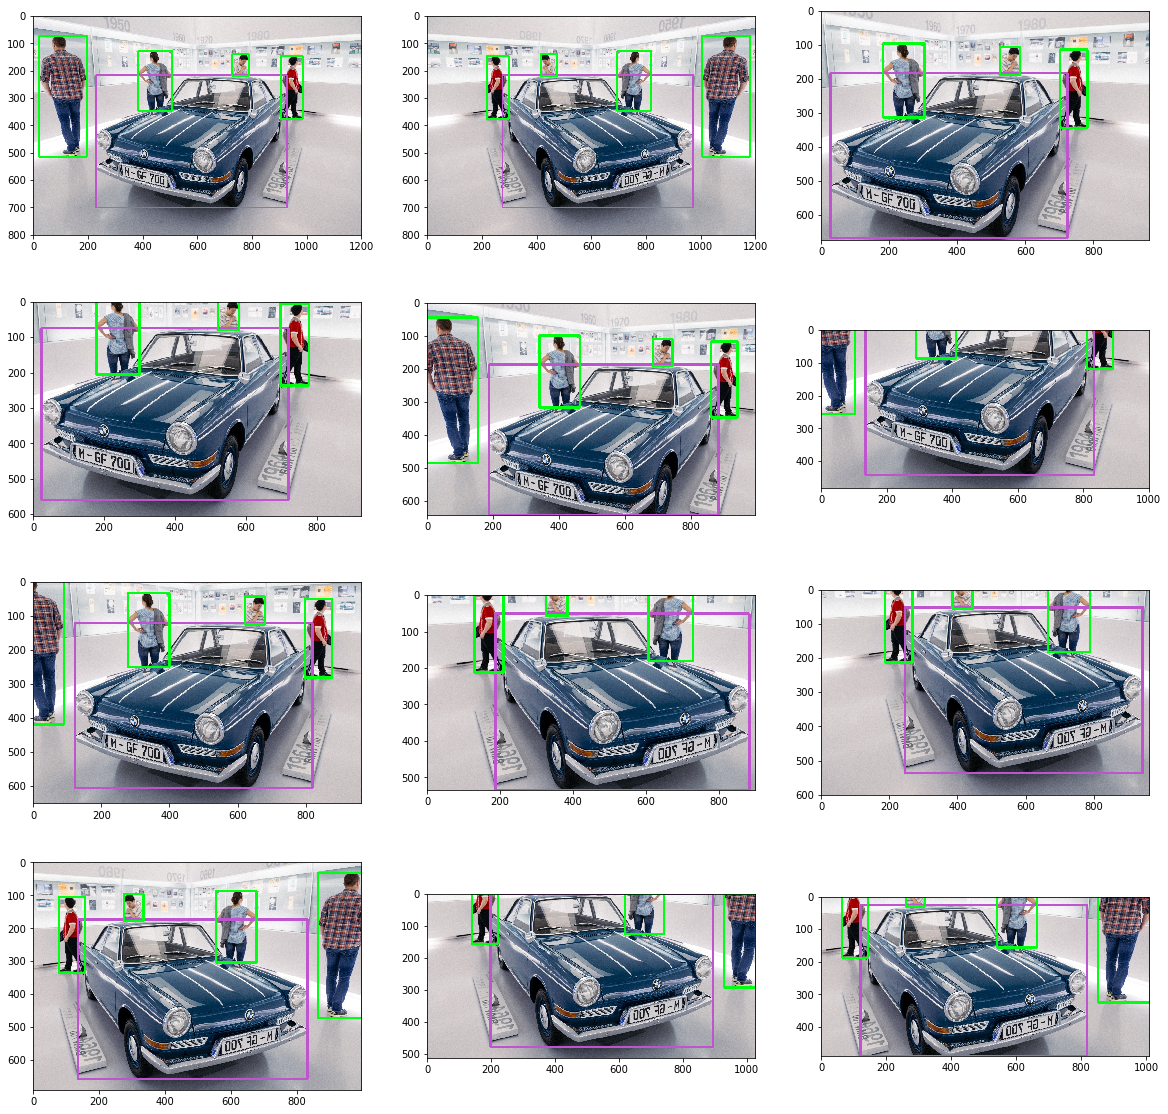

In [12]:
f = plt.figure(figsize=(20, 20))

ncols = 3
nrows = math.ceil(len(aug_results_debug) / ncols)

index = 1
for aug_img, aug_ann in aug_results_debug:
    draw_img = np.copy(aug_img)
    aug_ann.draw_contour(draw_img, thickness=5)
    
    f.add_subplot(nrows, ncols, index)
    plt.imshow(draw_img)
    
    index += 1

plt.show()